# Goals

1. Words between anaphor and antecedent (gold vs pred)
2. Is the closest antecedent always selected (gold vs pred)
3. Difference in predictions
4. Is an anaphor selected as the antecedent (preproc bug)

In [1]:
from pathlib import Path
import numpy as np
from copy import deepcopy
import json
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

In [2]:
from dataloader import DataLoader
from config import LOCATIONS as LOC
from evaluate.base import BaseEvaluationBench as BEB
from basicstats import _count_words_between_, _count_sents_between_

Fixing paths from /home/priyansh/Dev/research/anaphor/new/src
Fixing paths from /home/priyansh/Dev/research/anaphor/new/src


In [3]:
crm = 'none'
dl = DataLoader('crac', 'arrau')
dl.dataset, dl.dataset_domain, dl.dataset_domain_filename

('crac', 'arrau', 'Trains_91.CONLL')

#### Get predictions from disk

In [4]:
def pull_preds(loc):
    ops = {}
    for fname in pred_loc.glob('*.pkl'):
        ops[str(fname).split('/')[-1].replace('.pkl', '')] = pickle.load(fname.open('rb'))
        
    return ops
    

In [5]:
pred_loc = LOC.predictions / dl.dataset / dl.dataset_domain / dl.dataset_domain_filename / crm 
ops = pull_preds(pred_loc)
ops.keys()

dict_keys(['glove', 'spanbert-attn', 'oracle', 'wordtovec', 'random', 'bert-attn'])

#### Confirming that the "true" part is consistent

In [6]:
prev_true = None
for apprnm, apprvl in ops.items():
    if prev_true is not None:
        assert (prev_true == apprvl['true']).all()
        
    prev_true = apprvl['true']

# Cross Validation Variation

**SpanBERT** over **CRAC/arrau/Trains_91.CONLL** 

- ACC: 0.30; 0.53; 0.61; 0.07; 0.46
- ACC mean: 0.40

# Prediction Variations
How much do predicted outputs differ amongst approaches

### Overall

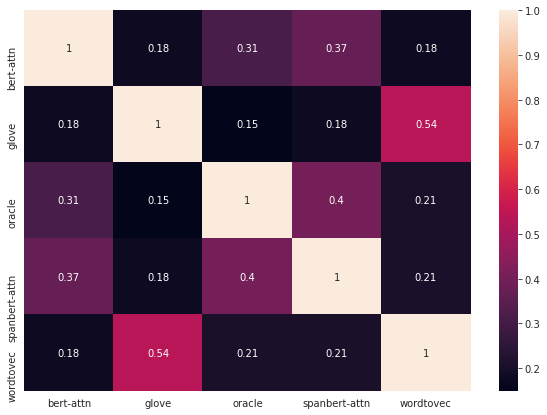

In [7]:
if True:
    # Conv predictions to indices instead of one hots
    preds = {k: np.argmax(v['pred'], axis=1) for k,v in ops.items()}

    keys = sorted(preds.keys())
    keys.pop(keys.index('random'))
    confmat = np.zeros((len(keys), len(keys)))
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys):
            confmat[i,j] = np.mean((preds[k1] == preds[k2])*1.0)

    df_cm = pd.DataFrame(confmat, index = [i for i in keys],
                      columns = [i for i in keys])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

### Correctly Predicted

i.e., say `spanbert` got 33 instances correctly. Then, amongst those 33 instances, how many times did `wordtovec`'s output match `spanbert`'s?

Row 2 (glove), Col 1 (bert-attn) - **0.7**: Amongst all the instances that were correctly predicted by glove, BERT Attn gave the same output as glove for 77% of those.

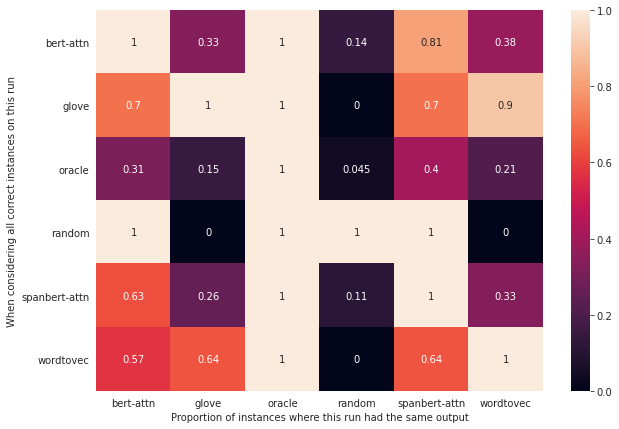

In [8]:
if True:
    # Conv predictions to indices instead of one hots
    preds = {k: np.argmax(v['pred'], axis=1) for k,v in ops.items()}

    keys = sorted(preds.keys())
    # keys.pop(keys.index('random'))
    confmat = np.zeros((len(keys), len(keys)))


    # Conv predictions to indices instead of one hots
    preds = {k: np.argmax(v['pred'], axis=1) for k,v in ops.items()}
    correct_preds, incorrect_preds = {}, {}
    for i, k1 in enumerate(keys):

        correct = preds[k1] == ops[k1]['true']
        i_preds_corr = preds[k1][correct]
        for j, k2 in enumerate(keys):

            # Put the correct index over the other preds and see how much do they match up
            j_preds = preds[k2][correct]
            confmat[i, j] = np.mean((i_preds_corr == j_preds)*1.0)

    # print(confmat)

    df_cm = pd.DataFrame(confmat, index = [i for i in keys],
                      columns = [i for i in keys])
    plt.figure(figsize = (10,7))
    confplot = sn.heatmap(df_cm, annot=True)
    confplot.set(xlabel ="Proportion of instances where this run had the same output", ylabel = "When considering all correct instances on this run")
    plt.show()

### Incorrectly predicted

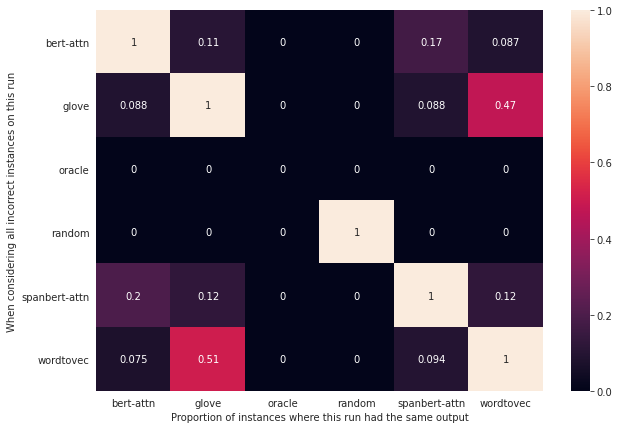

In [9]:
if True:
    # Conv predictions to indices instead of one hots
    preds = {k: np.argmax(v['pred'], axis=1) for k,v in ops.items()}

    keys = sorted(preds.keys())
    # keys.pop(keys.index('random'))
    confmat = np.zeros((len(keys), len(keys)))


    # Conv predictions to indices instead of one hots
    preds = {k: np.argmax(v['pred'], axis=1) for k,v in ops.items()}
    correct_preds, incorrect_preds = {}, {}
    for i, k1 in enumerate(keys):
        
        if k1 == 'oracle':
            continue
        incorrect = preds[k1] != ops[k1]['true']
        i_preds_corr = preds[k1][incorrect]
        for j, k2 in enumerate(keys):

            # Put the correct index over the other preds and see how much do they match up
            j_preds = preds[k2][incorrect]
            confmat[i, j] = np.mean((i_preds_corr == j_preds)*1.0)

    # print(confmat)

    df_cm = pd.DataFrame(confmat, index = [i for i in keys],
                      columns = [i for i in keys])
    plt.figure(figsize = (10,7))
    confplot = sn.heatmap(df_cm, annot=True)
    confplot.set(xlabel ="Proportion of instances where this run had the same output", ylabel = "When considering all incorrect instances on this run")
    plt.show()

# Average nr. words between anaphor and antecedent
diff. b/w gold and pred

In [10]:
distances = []

for apprnm in ops:

    distances_pred = []
    distances_gold = []
    instances = ops[apprnm]['instances']
    golds = ops[apprnm]['true']
    preds = ops[apprnm]['pred']
    for instance, gold, pred in zip(instances, golds, preds):
        anaphor_span = instance.anaphor
        pred_ante_span = instance.candidate_nounphrase_ids[np.argmax(pred)]
        gold_ante_span = instance.candidate_nounphrase_ids[gold]

        distances_pred.append(_count_words_between_(pred_ante_span, anaphor_span))
        distances_gold.append(_count_words_between_(gold_ante_span, anaphor_span))

    distances_pred = np.asarray(distances_pred)
    distances_gold = np.asarray(distances_gold)
    distances_gap = np.abs(distances_gold - distances_pred).nonzero()[0]

    distances.append(
    {
        'approach': apprnm,
        'mean_gold': f"{np.mean(distances_gold):.2f} ± {np.std(distances_gold):.2f}",
        'mean_pred': f"{np.mean(distances_pred):.2f} ± {np.std(distances_pred):.2f}",
        'max_gold': np.max(distances_gold),
        'max_pred': np.max(distances_pred),
        'min_gold': np.max(distances_gold),
        'min_pred': np.min(distances_pred)
    })

    if distances_gap.any():
        distances[-1]['mean_gap'] = f"{np.mean(distances_gap):.2f} ± {np.std(distances_gap):.2f}",
        distances[-1]['min_gap'] = np.min(distances_gap)
        distances[-1]['max_gap'] = np.max(distances_gap)
    else:
        distances[-1]['mean_gap'] = np.nan
        distances[-1]['min_gap'] = np.nan
        distances[-1]['max_gap'] = np.nan

pd.DataFrame(distances)

approach       mean_gold        mean_pred  max_gold  max_pred  \
0          glove  98.96 ± 164.81  306.84 ± 397.50       795      1767   
1  spanbert-attn  98.96 ± 164.81   73.75 ± 101.77       795       385   
2         oracle  98.96 ± 164.81   98.96 ± 164.81       795       795   
3      wordtovec  98.96 ± 164.81  363.03 ± 404.83       795      1767   
4         random  98.96 ± 164.81  347.25 ± 378.65       795      1898   
5      bert-attn  98.96 ± 164.81  101.12 ± 106.87       795       391   

   min_gold  min_pred          mean_gap  min_gap  max_gap  
0       795         6  (31.18 ± 19.55,)      0.0     65.0  
1       795         0  (33.41 ± 19.92,)      0.0     66.0  
2       795         0               NaN      NaN      NaN  
3       795         9  (31.12 ± 19.81,)      0.0     65.0  
4       795         7  (33.30 ± 19.69,)      0.0     66.0  
5       795         0  (28.30 ± 19.00,)      0.0     65.0

# Average nr. sentences between anaphor and antecedent

diff. b/w gold and pred

In [11]:
distances = []

for apprnm in ops:

    distances_pred = []
    distances_gold = []
    instances = ops[apprnm]['instances']
    golds = ops[apprnm]['true']
    preds = ops[apprnm]['pred']
    for instance, gold, pred in zip(instances, golds, preds):
        anaphor_span = instance.anaphor
        pred_ante_span = instance.candidate_nounphrase_ids[np.argmax(pred)]
        gold_ante_span = instance.candidate_nounphrase_ids[gold]

        distances_pred.append(_count_sents_between_(pred_ante_span, anaphor_span, instance))
        distances_gold.append(_count_sents_between_(gold_ante_span, anaphor_span, instance))

    distances_pred = np.asarray(distances_pred)
    distances_gold = np.asarray(distances_gold)
    distances_gap = np.abs(distances_gold - distances_pred).nonzero()[0]

    distances.append(
    {
        'approach': apprnm,
        'mean_gold': f"{np.mean(distances_gold):.2f} ± {np.std(distances_gold):.2f}",
        'mean_pred': f"{np.mean(distances_pred):.2f} ± {np.std(distances_pred):.2f}",
        'max_gold': np.max(distances_gold),
        'max_pred': np.max(distances_pred),
        'min_gold': np.max(distances_gold),
        'min_pred': np.min(distances_pred)
    })

    if distances_gap.any():
        distances[-1]['mean_gap'] = f"{np.mean(distances_gap):.2f} ± {np.std(distances_gap):.2f}",
        distances[-1]['min_gap'] = np.min(distances_gap)
        distances[-1]['max_gap'] = np.max(distances_gap)
    else:
        distances[-1]['mean_gap'] = np.nan
        distances[-1]['min_gap'] = np.nan
        distances[-1]['max_gap'] = np.nan

pd.DataFrame(distances)

approach     mean_gold      mean_pred  max_gold  max_pred  min_gold  \
0          glove  7.06 ± 11.20  19.93 ± 25.40        62       126        62   
1  spanbert-attn  7.06 ± 11.20    5.43 ± 7.14        62        27        62   
2         oracle  7.06 ± 11.20   7.06 ± 11.20        62        62        62   
3      wordtovec  7.06 ± 11.20  23.90 ± 26.96        62       126        62   
4         random  7.06 ± 11.20  22.49 ± 24.94        62       131        62   
5      bert-attn  7.06 ± 11.20    6.43 ± 6.39        62        20        62   

   min_pred          mean_gap  min_gap  max_gap  
0         0  (29.85 ± 19.00,)      0.0     64.0  
1         0  (31.79 ± 19.42,)      0.0     66.0  
2         0               NaN      NaN      NaN  
3         0  (30.71 ± 19.51,)      0.0     65.0  
4         0  (33.07 ± 19.76,)      0.0     65.0  
5         0  (27.55 ± 19.55,)      0.0     65.0

# Stuff no one got right

In [12]:
relevant_keys = ['wordtovec', 'glove', 'spanbert-attn', 'bert-attn']

incorrects = {}
for k in relevant_keys:
    # Find incorrect ones for this approach
    incorrects[k] = np.argmax(ops[k]['pred'], axis=1) != ops[k]['true']
    
# Find intersections

intr = np.logical_and(incorrects['wordtovec'],  incorrects['glove'])
print("Common incorrect instances b/w w2v and glove: ", np.sum(intr * 1.0))
intr2 = np.logical_and(incorrects['spanbert-attn'], incorrects['bert-attn'])
print("Common incorrect instances b/w bert and spanbert: ", np.sum(intr2 * 1.0))
intra = np.logical_and(intr, intr2)
print("Common incorrect instances b/w all approaches: ", np.sum(intra * 1.0))

Common incorrect instances b/w w2v and glove:  52.0
Common incorrect instances b/w bert and spanbert:  36.0
Common incorrect instances b/w all approaches:  32.0
